In [1]:
%reload_ext autoreload
%autoreload 2

from skimage import io
import cv2
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
import numpy as np
from numpy.matlib import repmat
import json
sys.path.append(str(Path(sys.path[0]).parent))
from write_static_flow import *

def read_depth(depth_file):
    depth = io.imread(depth_file)
    # depth = depth[:,:,::-1]
    depth = depth[:, :, 0] * 1.0 + depth[:, :, 1] * 256.0 + depth[:, :, 2] * (256.0 * 256)
    depth = depth * (1/ (256 * 256 * 256 - 1)) * 1000
    return depth

In [2]:
def vis_flow(flow):
    # create HSV & make Value a constant
    hsv = np.zeros((512,1382,3))
    hsv[:,:,1] = 255

    # Encoding: convert the algorithm's output into Polar coordinate
    flow_reshaped = flow.reshape((512,1382,-1))
    mag, ang = cv2.cartToPolar(flow_reshaped[...,0], flow_reshaped[...,1])
    # Use Hue and Value to encode the Optical Flow
    hsv[:,:, 0] = ang * 180 / np.pi / 2
    hsv[:,:, 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    # Convert HSV image into BGR for demo
    bgr = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
    return bgr

def plot_triplets(first, second, third):
    #plotting
    fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(30, 8))
    ax1.imshow(first)
    ax1.set_title("Raw_saving")
    ax2.imshow(second)
    ax2.set_title("Depth carla converter")
    ax3.imshow(third)
    ax3.set_title("Log depth carla converter")
    plt.show()

In [3]:
first_image_idx = 58
offset = 1
root = "/Carla_Data_Collection/Depth_Test/"
# root = "/storage/remote/atcremers40/motion_seg/datasets/Carla_Data_Collection/Depth_Test/"

## Visualizing RGB images

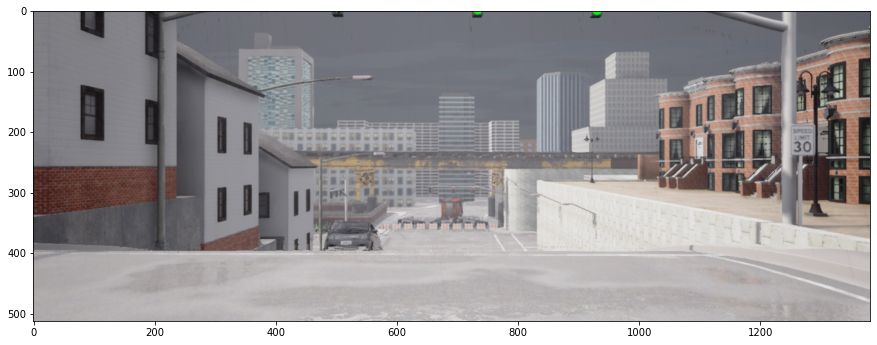

In [13]:
rgb = plt.imread(os.path.join(root, "images/%04d.png"%first_image_idx))

plt.figure(figsize=(15,8))
plt.imshow(rgb)

In [14]:
#Raw saving
raw_path = os.path.join(root, "depth/raw")
raw_trs_path = os.path.join(root,"transformations/")
raw_d_img = os.path.join(raw_path, "%04d.png"%first_image_idx)
# raw_img = plt.imread(os.path.join(raw_path, "images/%04d.png"%first_image_idx))
raw = read_depth(raw_d_img)

#Depth saving
depth_path = os.path.join(root,"depth/normal_depth")
depth_trs_path = os.path.join(root,"transformations/")
depth = plt.imread(os.path.join(depth_path, "%04d.png"%first_image_idx))
# depth_img = plt.imread(os.path.join(depth_path, "images/%04d.png"%first_image_idx))

#Log depth saving
log_depth_path = os.path.join(root,"depth/log_depth")
log_depth_trs_path = os.path.join(root,"transformations/")
log_depth = plt.imread(os.path.join(log_depth_path, "%04d.png"%first_image_idx))
# log_depth_img = plt.imread(os.path.join(log_depth_path, "images/%04d.png"%first_image_idx))

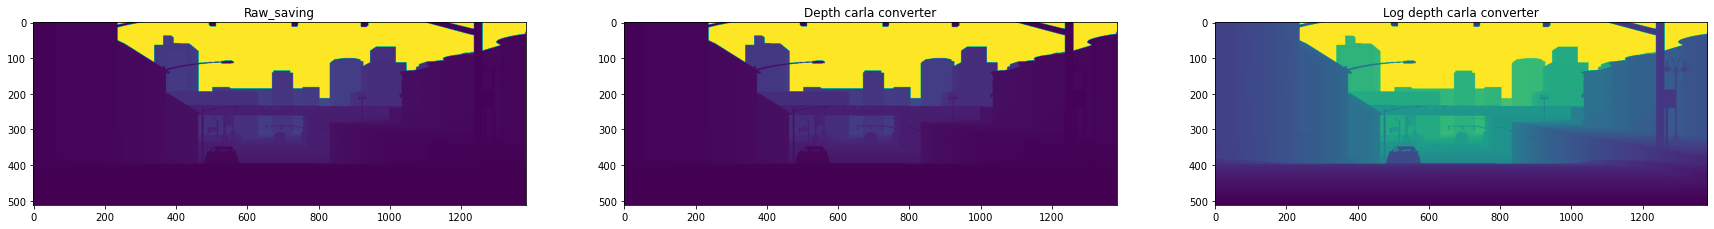

In [15]:
plot_triplets(raw, depth, log_depth)

In [16]:
offset = 1

def transforms(offset, idx, trs_path):
    trs_path = os.path.join(trs_path, "transforms.json")
    with open(trs_path, "r") as f:
        trs_json = json.load(f)["transforms"]

    trs = np.array(trs_json[idx+offset])
    return trs

#Raw saving
raw_trs = transforms(offset, first_image_idx, raw_trs_path)
# print(raw_trs.shape, raw_trs)

#Depth
depth_trs = transforms(offset, first_image_idx, depth_trs_path)

#LogDepth
log_depth_trs = transforms(offset, first_image_idx, log_depth_trs_path)

In [17]:
opt_flow_raw = get_flow(raw/1000, raw_trs)
vis_flow_raw = vis_flow(opt_flow_raw)

opt_flow_depth = get_flow(depth, depth_trs)
vis_flow_depth = vis_flow(opt_flow_depth)


opt_flow_log_depth = get_flow(log_depth*255, log_depth_trs)
vis_flow_log_depth = vis_flow(opt_flow_log_depth)

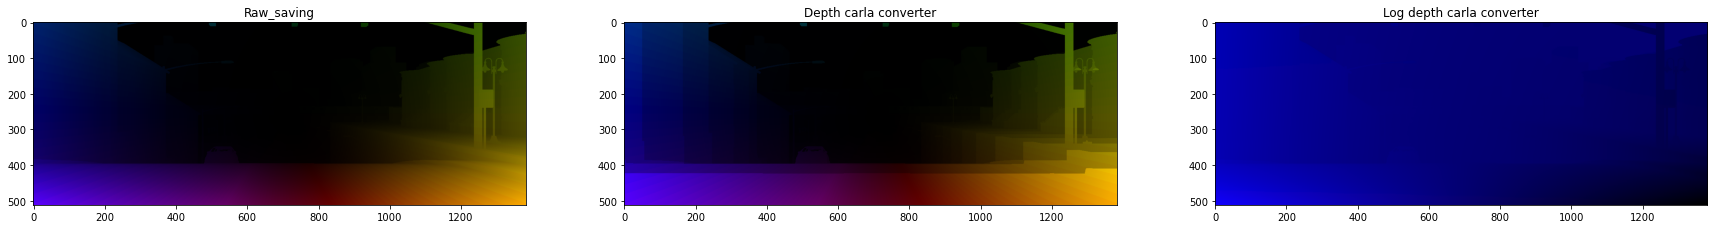

In [21]:
plot_triplets(vis_flow_raw, vis_flow_depth, vis_flow_log_depth)

<ipython-input-22-2656785a6938>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


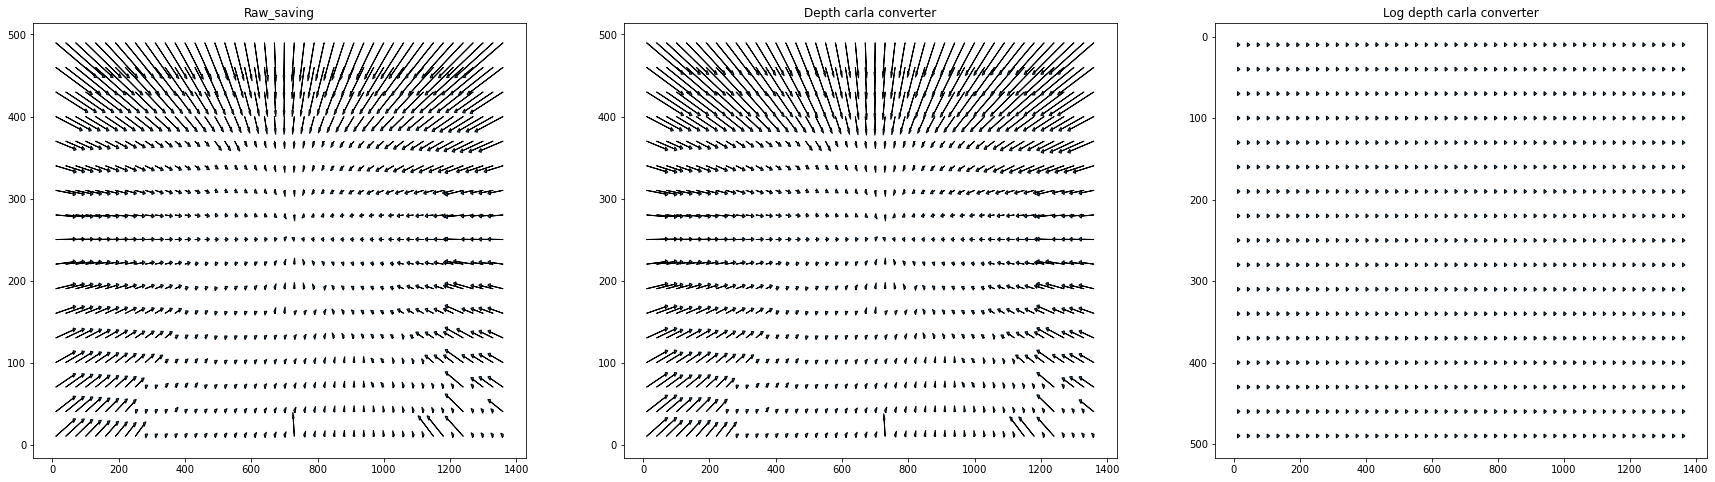

In [22]:
def plot_triplet_arrows(first, second, third):
    #Visualization of flow vectors 

    fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(30, 8))
    # plt.gca().invert_yaxis()
    ax1.invert_yaxis()
    ax2.invert_yaxis()
    ax3.invert_yaxis()

    disc_step = 30
    of_offset = 10

    for i in range(of_offset, first.shape[0]-of_offset, disc_step):
        for j in range(of_offset,first.shape[1]-of_offset, disc_step):
            ax1.arrow(j,i,first[i,j,0], first[i,j,1], head_width=5)
    ax1.set_title("Raw_saving")
    
    for i in range(of_offset, second.shape[0]-of_offset, disc_step):
        for j in range(of_offset,second.shape[1]-of_offset, disc_step):
            ax2.arrow(j,i,second[i,j,0], second[i,j,1], head_width=5)
    ax2.set_title("Depth carla converter")
    
    for i in range(of_offset, third.shape[0]-of_offset, disc_step):
        for j in range(of_offset,third.shape[1]-of_offset, disc_step):
            ax3.arrow(j,i,third[i,j,0], third[i,j,1], head_width=5)
    ax3.set_title("Log depth carla converter")
    fig.show()

plot_triplet_arrows(opt_flow_raw, opt_flow_depth, opt_flow_log_depth)
